
# Recursive forecasting example
Feature Engineering for Time Series Forecasting

In this notebook we will show how to use trend features in a recursive forecasting workflow where we also have features built from the target (e.g., lag & window features).

In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('talk')

## Data set sypnosis

The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s.

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

In [2]:
data = pd.read_csv('../datasets/example_air_passengers.csv',
                  parse_dates=['ds'],
                  index_col=['ds'])

In [3]:
data.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Plot the data

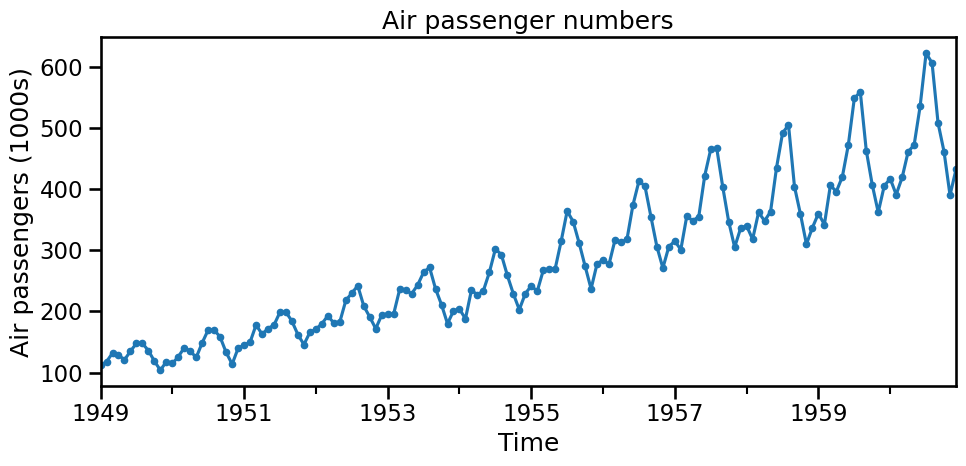

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))

data.plot(y='y', marker='.', figsize=(10, 5), legend=None, ax=ax)
ax.set_ylabel('Air passengers (1000s)')
ax.set_xlabel('Time')
ax.set_title('Air passenger numbers')
plt.tight_layout()

## Build some forecasts

Build a recursive forecast and see how our trend feature can help

In [5]:
from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

set_config(transform_output='pandas')

In [6]:
df = data.copy()

df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Specify target name

In [7]:
target = ['y']

Prepare transformers

In [8]:
# polynomial time features
time_feats = make_pipeline(
    TimeSince(freq='MS'),
    PolynomialFeatures(degree=2, include_bias=False)
)

# features computed from the target
# compute lag and window features
lag_window_feats = WindowSummarizer(
    lag_feature={
        'lag': [1,2,3,12],     # lag features
        'mean': [[1, 12]],     # [[lag, window size]]
    },
    target_cols=target,
    truncate='bfill',          # backfill missing values from lagging and windowing
)

Create a pipelien to create all our features

In [9]:
# create features derived independent of one another
pipeline = make_union(time_feats, lag_window_feats)

In [10]:
# apply min-max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())

In [11]:
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince(freq='MS')),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1, 2, 3, 12], 'mean': [[1, 12]]},
                 target_cols=['y'], truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

In [12]:
pipeline.fit_transform(df)

,time_since_1949-01-01 00:00:00,time_since_1949-01-01 00:00:00^2,y_lag_1,y_lag_2,y_lag_3,y_lag_12,y_mean_1_12
ds,,,,,,,
1949-01-01,0.000000,0.000000,0.015444,0.015444,0.015444,0.017582,0.000000
1949-02-01,0.006993,0.000049,0.015444,0.015444,0.015444,0.017582,0.000000
1949-03-01,0.013986,0.000196,0.027027,0.015444,0.015444,0.017582,0.000000
1949-04-01,0.020979,0.000440,0.054054,0.027027,0.015444,0.017582,0.000000
1949-05-01,0.027972,0.000782,0.048263,0.054054,0.027027,0.017582,0.000000
...,...,...,...,...,...,...,...
1960-08-01,0.972028,0.944838,1.000000,0.832046,0.710425,1.000000,0.958243
1960-09-01,0.979021,0.958482,0.969112,1.000000,0.832046,0.789011,0.969522
1960-10-01,0.986014,0.972224,0.779923,0.969112,1.000000,0.665934,0.980322


In [13]:
# we can use `clone` to return an unfitted version of the pipeline
pipeline = clone(pipeline)

Let's build a recursive forecast. We'll start with configuring the forecast start time, the number of steps to forecast, and the forecasting horizon, and the model.

In [14]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

In [15]:
# CONFIG
# define time of first forecast
forecast_start_time = pd.to_datetime('1955-10-01')

# define number of steps to forecast
num_of_forecast_steps = 36

# define the model
model = LinearRegression()

# Create a list of periods that we'll forecast over
forecast_horizon = pd.date_range(
    start=forecast_start_time,
    periods=num_of_forecast_steps,
    freq='MS'
)

# how much data in the past is needed to create our features
# we need the latest 12 time periods in our predict dataframe to build our window features
look_back_window_size = pd.DateOffset(months=12)

Create training dataframe

In [16]:
# CREATE TRAINING AND TESTING DATAFRAME
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

Compute `X_train` and `y_train` and fit the model

In [17]:
# create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

# Model training
# train one-step ahead forecast model
model.fit(X_train, y_train)

LinearRegression()


Let's prepare the dataframe that we will pass to `pipeline.transform()` to create `X_test` that we pass to `model.predict()`. This will contain some portion of time series during the training period so we can create any features that require historic data. Let's visualise the process that we are going to set up.

In [18]:
# CREATE DYNAMIC PREDICTION DATAFRAME
# We will recursively append our forecasts to this
# dataframe and re-compute our lag and window features from the
# target in this dataframe. It contains data in both the training period
# and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# create `df_predict` which has data going as far back as needed
# to create features which need past values
df_predict = df_train.loc[look_back_start_time:].copy()

# extend index into forecast horizon
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

In [19]:
df_predict

,y
1954-10-01,229.0
1954-11-01,203.0
1954-12-01,229.0
1955-01-01,242.0
1955-02-01,233.0
1955-03-01,267.0
1955-04-01,269.0
1955-05-01,270.0
1955-06-01,315.0
1955-07-01,364.0


Let's recursively create `X_test` and make our predictions and append them to the `df_predict` dataframe.

In [20]:
# RECURSIVE FORECASTING LOOP
for forecast_time in forecast_horizon:
    # compute features during teh forecast horizon
    X_test = pipeline.transform(df_predict[:forecast_time])
    X_test_ = X_test.loc[[forecast_time]]

    # predict one step ahead
    y_pred = model.predict(X_test_)

    # append forecast to the target variable column in our dynamic forecast dataframe `df_predict`
    # This `df_predict` is ready for next iteration where we will re-compute features derived 
    # from the target such as lags and windows
    df_predict.loc[[forecast_time], target] = y_pred

In [21]:
df_predict

,y
1954-10-01,229.000000
1954-11-01,203.000000
1954-12-01,229.000000
1955-01-01,242.000000
1955-02-01,233.000000
1955-03-01,267.000000
1955-04-01,269.000000
1955-05-01,270.000000
1955-06-01,315.000000
1955-07-01,364.000000


Retrieve our forecast and actuals during the forecast horizon

In [22]:
# GET FORECAST AND TEST VALUES
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

Create predictions on the training set using one step ahead forecast model. It is useful to plot when debugging models.

In [23]:
# CREATE IN-SAMPLE PREDICTIONS
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

Plot the forecast

Text(0.5, 1.0, 'Forecast with LinearRegression()')

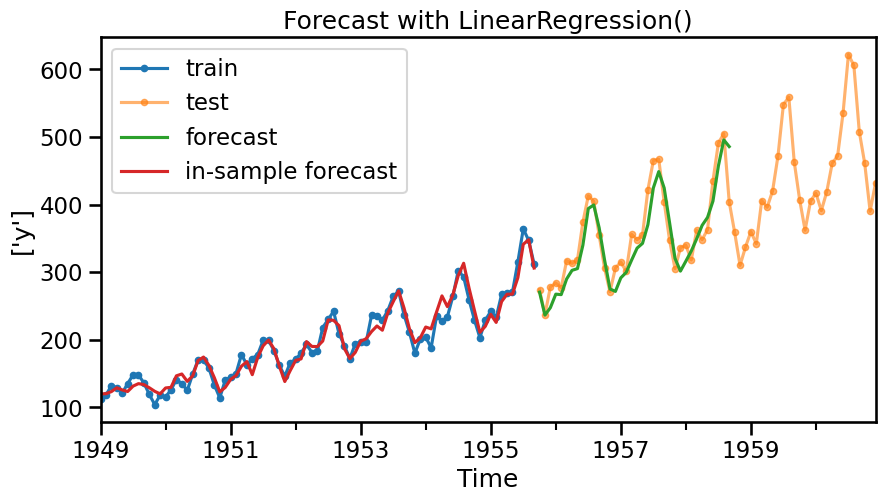

In [24]:

# --- PLOTTING --- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[10, 5])

# Plot training set.
y_train.plot(ax=ax, marker=".")
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker=".", alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Forecast with {model}")

Let's look at the model coefficients

In [26]:
pd.Series(index=X_train.columns, data=model.coef_[0])

time_since_1949-01-01 00:00:00       29.129878
time_since_1949-01-01 00:00:00^2     10.389300
y_lag_1                             117.517713
y_lag_2                             -43.930508
y_lag_3                               5.660513
y_lag_12                            155.095420
y_mean_1_12                         -37.411969
dtype: float64

Compute the RMSE of this forecast

In [27]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_test.loc[y_forecast.index], y_forecast)

26.51057268359753


We can now implement the time feature to capture trend alongside other features in a recursive forecasting workflow. We can see that the time feature can help capture the trend in the data when using linear models.

Feel free to change the dates, try different models, and different features!